# Fake News Detection (auto-merge Fake.csv & True.csv)

This notebook automatically detects `Fake.csv` and `True.csv` (ISOT dataset), merges them into
`data/fake_or_real_news.csv`, and runs a full pipeline: preprocessing → TF-IDF → LogisticRegression → evaluation.

Place `Fake.csv` and `True.csv` in the same folder as this notebook and run all cells.

## Requirements

If running locally, install required packages:

```bash
pip install pandas scikit-learn joblib matplotlib seaborn nltk
```

In [1]:
# Auto-detect and merge Fake.csv and True.csv into data/fake_or_real_news.csv
import os
import pandas as pd

fake_path = 'Fake.csv'
true_path = 'True.csv'
out_dir = 'data'
out_path = os.path.join(out_dir, 'fake_or_real_news.csv')

if os.path.exists(out_path):
    print(f"Found existing combined dataset at {out_path} (will use it).")
else:
    if os.path.exists(fake_path) and os.path.exists(true_path):
        print("Found Fake.csv and True.csv — merging them now...")
        fake = pd.read_csv(fake_path)
        true = pd.read_csv(true_path)
        fake['label'] = 'fake'
        true['label'] = 'real'
        df = pd.concat([fake, true], axis=0, ignore_index=True)
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        os.makedirs(out_dir, exist_ok=True)
        # Keep only useful columns (title, text, label). If title missing, create empty.
        if 'title' not in df.columns:
            # Try common alternatives
            for alt in ['headline','Head lines','headline_text']:
                if alt in df.columns:
                    df = df.rename(columns={alt:'title'})
                    break
            if 'title' not in df.columns:
                df['title'] = ''
        if 'text' not in df.columns and 'content' in df.columns:
            df = df.rename(columns={'content':'text'})
        if 'text' not in df.columns:
            # Try to combine other text columns
            text_cols = [c for c in df.columns if 'text' in c.lower() or 'article' in c.lower() or 'content' in c.lower()]
            if text_cols:
                df['text'] = df[text_cols].astype(str).agg(' '.join, axis=1)
            else:
                # fallback: join all columns
                df['text'] = df.drop(columns=['label']).astype(str).agg(' '.join, axis=1)
        df[['title','text','label']].to_csv(out_path, index=False)
        print(f"Saved combined dataset to {out_path} — rows: {len(df)}")
    else:
        print("Did not find a combined dataset and missing Fake.csv or True.csv.")
        print("Please place Fake.csv and True.csv in the notebook folder, or upload a combined data/fake_or_real_news.csv")


Found Fake.csv and True.csv — merging them now...
Saved combined dataset to data\fake_or_real_news.csv — rows: 44898


In [2]:
# Imports and NLTK setup
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib

import nltk
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/wordnet')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('wordnet')
    nltk.download('stopwords')

print('Libraries loaded')

Libraries loaded


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pubgs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pubgs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pubgs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load combined dataset and Basic EDA

In [3]:
DATA_PATH = 'data/fake_or_real_news.csv'
if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH)
    print('Loaded', len(df), 'rows from', DATA_PATH)
    display(df.head())
    print('\nColumns:', df.columns.tolist())
    print('\nMissing values per column:')    
    print(df.isnull().sum())
    if 'label' in df.columns:
        print('\nLabel distribution:') 
        print(df['label'].value_counts())
else:
    print('Combined dataset not found. Run the previous merge cell or upload the combined CSV.')

Loaded 44898 rows from data/fake_or_real_news.csv


,title,text,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",fake
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,real
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,real
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",fake
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",real



Columns: ['title', 'text', 'label']

Missing values per column:
title    0
text     0
label    0
dtype: int64

Label distribution:
label
fake    23481
real    21417
Name: count, dtype: int64


## Preprocessing
Lowercase, remove URLs/HTML, punctuation, stopwords and lemmatize.

In [4]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

url_re = re.compile(r'https?://\S+|www\.\S+')
html_re = re.compile(r'<.*?>')

def clean_text(text, remove_stopwords=True, do_lemmatize=True):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = url_re.sub(' ', text)
    text = html_re.sub(' ', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    tokens = text.split()
    if remove_stopwords:
        tokens = [t for t in tokens if t not in STOPWORDS]
    if do_lemmatize:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

if 'df' in globals():
    df['title'] = df.get('title','').fillna('')
    df['text'] = df.get('text','').fillna('')
    df['combined'] = (df['title'].astype(str) + ' ' + df['text'].astype(str)).str.strip()
    df['clean_text'] = df['combined'].apply(clean_text)
    display(df[['title','clean_text']].head())
else:
    print('Load the combined dataset first')

,title,clean_text
0,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein call 9th circuit court committed cou...
1,Trump drops Steve Bannon from National Securit...,trump drop steve bannon national security coun...
2,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expects u lift jones act shipping ...
3,OOPS: Trump Just Accidentally Confirmed He Le...,oops trump accidentally confirmed leaked israe...
4,Donald Trump heads for Scotland to reopen a go...,donald trump head scotland reopen golf resort ...


## Feature extraction + Modeling
TF-IDF (1-2 grams) + Logistic Regression baseline.

Training...
Done

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4284
           1       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

ROC AUC: 0.9993334216139608


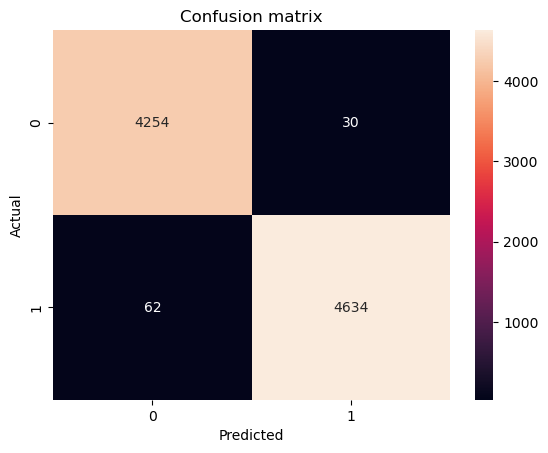

In [5]:
if 'df' in globals():
    X = df['clean_text'].astype(str)
    y = df['label'].copy()
    # map labels to 0/1 if needed
    if y.dtype == object:
        if set(y.unique()).issuperset({'fake','real'}):
            y = y.map({'fake':1, 'real':0})
        else:
            y = pd.factorize(y)[0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=50000)),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    print('Training...')
    pipe.fit(X_train, y_train)
    print('Done')
    preds = pipe.predict(X_test)
    probs = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, 'predict_proba') else None
    print('\nClassification report:')
    print(classification_report(y_test, preds))
    if probs is not None:
        print('ROC AUC:', roc_auc_score(y_test, probs))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print('Data not loaded — upload combined CSV and re-run')

## Save trained model

In [6]:
if 'pipe' in globals():
    os.makedirs('models', exist_ok=True)
    joblib.dump(pipe, 'models/fake_news_tfidf_logreg_v2.joblib')
    print('Saved model to models/fake_news_tfidf_logreg_v2.joblib')
else:
    print('No trained model found')

Saved model to models/fake_news_tfidf_logreg_v2.joblib


## Predict on new text examples

In [7]:
def predict_texts(texts, model_path='models/fake_news_tfidf_logreg_v2.joblib'):
    m = joblib.load(model_path)
    cleaned = [clean_text(t) for t in texts]
    preds = m.predict(cleaned)
    probs = m.predict_proba(cleaned)[:,1] if hasattr(m, 'predict_proba') else None
    return preds, probs

if os.path.exists('models/fake_news_tfidf_logreg_v2.joblib'):
    examples = [
        'Breaking: scientists discover new treatment for disease',
        'You won’t believe what this celebrity did — click here!'
    ]
    p, pr = predict_texts(examples)
    for e, pp, prob in zip(examples, p, pr):
        print(f"{e[:80]}... => pred={pp}, prob={prob:.3f}")
else:
    print('Train and save the model first to run predictions')

Breaking: scientists discover new treatment for disease... => pred=1, prob=0.869
You won’t believe what this celebrity did — click here!... => pred=1, prob=0.827


## Next steps / Improvements

- Try other classifiers (SVM, XGBoost), hyperparameter tuning, class weighting.
- Use character n-grams for robustness, and experiment with transformers (BERT/RoBERTa) for higher accuracy.
- Add metadata features (source, date) if available.

---

This notebook auto-merges Fake.csv and True.csv from the ISOT dataset. If your files have different column names, the merge step attempts to adapt (renaming common alternatives).